# PARTE 1. PROCESO DE ETL CON BASE DE DATOS
### Nombre de la asignatura: Mineria de Datos
### Carrera: Tecnologia Superior en Big Data
### Estudiante: Danny Pineda
### Fecha: 26/04/2024

### Objetivos de la Práctica:
En la siguiente práctica se realizará el proceso de Extracción, Transformación y Carga de Datos.

En primera instancia se debe de crear la estructura de la base de datos para ello se adjunta el script de la base de datos. En mysql cuyo nombre es: Dump20240109.ssql


### 1. Importamos las librerías

Si no tiene instalado la librería mysql.connector debe de ejecutar la siguiente línea de comandos.

In [126]:
#!pip install mysql.connector

In [127]:
import mysql.connector
import pandas as pd

In [128]:
#!pip install xlrd

### 2. Cargamos la data

In [129]:
# Especifica la ruta de tu archivo Excel
ruta_archivo_excel = "Datos_Taxis.xls"

# Lee el archivo Excel y conviértelo a un DataFrame
df = pd.read_excel(ruta_archivo_excel)

# Muestra las primeras filas del DataFrame
df.head()


,Placa,Clase,Marca,Año de fabricación del taxi,Categoría,Tipo taxi
0,AP-000024,Taxi Aeropuerto,Toyota,1990,Automovil,Sedan
1,AP-000033,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
2,AP-000035,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan
3,AP-000049,Taxi Aeropuerto,Volvo,1990,Automovil,Sedan
4,AP-000074,Taxi Aeropuerto,Nissan,1990,Automovil,Sedan


### 3. Proceso de extracción y Carga de Datos

### 3.1. Conexión a la base de datos

Para esta sección debe de ejecutar o importar el script de la base de datos.

In [130]:
#Método para conectar a la base de datos
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

In [131]:
conexion = establecer_conexion("localhost", "root", "", "taxis")
#Comprobación de la conexión
conexion.is_connected()

True

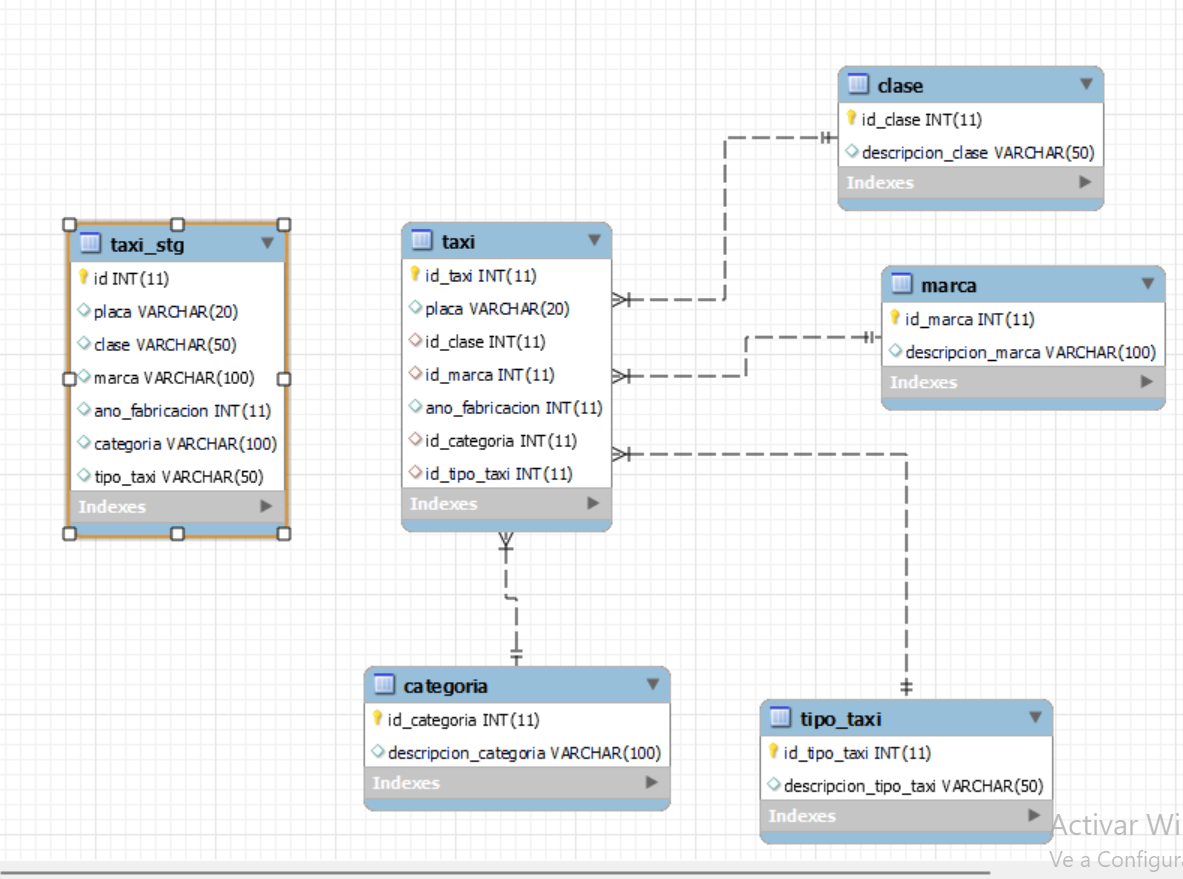

In [156]:
from IPython.display import Image

Image(filename='base_taxi.png')

### 3.2. Eliminar los datos de la base de datos

In [132]:
def eliminar_datos_base(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación de datos
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")
        conexion.commit()
        cursor.close()

        # Limpiar la base de datos
        cursor = conexion.cursor()
        cursor.execute("DELETE FROM clase;")
        cursor.execute("DELETE FROM marca;")
        cursor.execute("DELETE FROM taxi;")
        cursor.execute("DELETE FROM categoria;")
        cursor.execute("DELETE FROM tipo_taxi;")
        cursor.execute("DELETE FROM taxi_stg;")
        # Realizar más operaciones de eliminación si es necesario
        conexion.commit()
        cursor.close()
    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")
    finally:
        try:
            # Reactivar las restricciones de clave externa
            cursor = conexion.cursor()
            cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
            cursor.close()
        except Exception as e:
            print(f"Error al reactivar las restricciones de clave externa: {e}")

# Llamar a la función eliminar_datos_base
eliminar_datos_base(conexion)


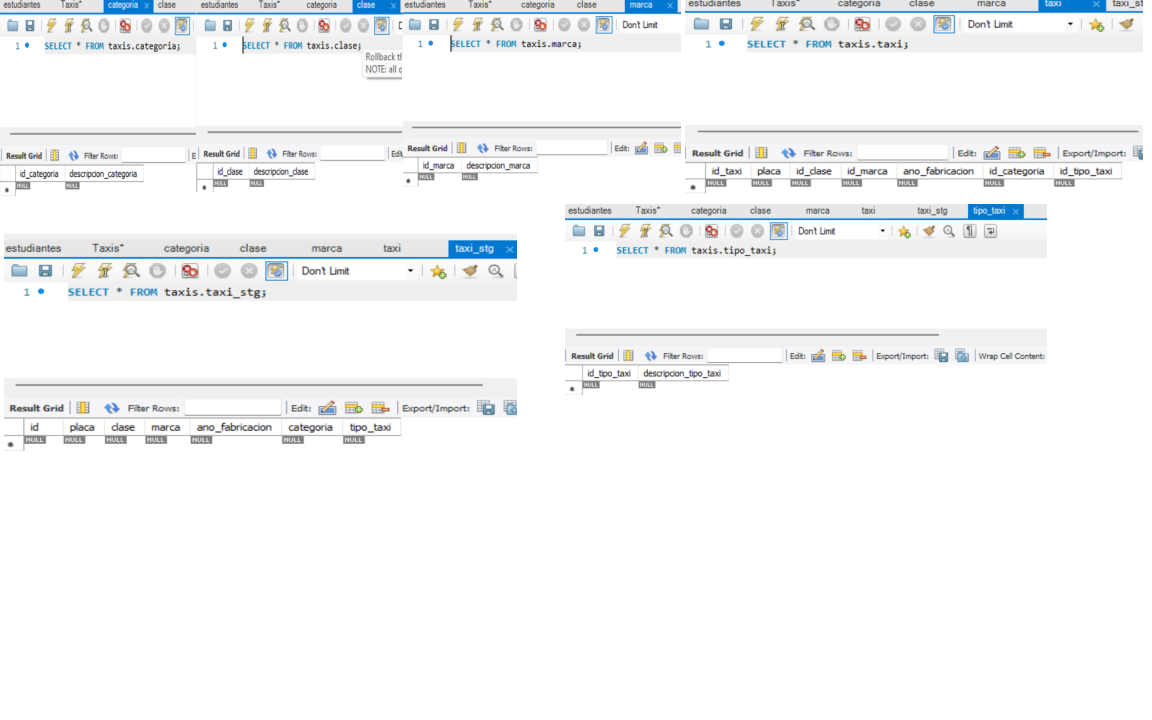

In [133]:
from IPython.display import Image

Image(filename='tablas_vacias.png')

### 3.3. Insertar datos a la tabla taxi

In [134]:
  
def insert_taxi_stg(conexion, df):
    cursor = conexion.cursor()

    insert_query = "INSERT INTO taxi_stg(placa,clase,marca, ano_fabricacion,categoria,tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

    try:
        for index, row in df.iterrows():
            taxi_data = (row['Placa'], row['Clase'], row['Marca'], row['Año de fabricación del taxi'], row['Categoría'], row['Tipo taxi'])
            cursor.execute(insert_query, taxi_data)

        conexion.commit()
        print(f"Datos insertados correctamente")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

    finally:
        cursor.close()

In [135]:
insert_taxi_stg(conexion, df)

Datos insertados correctamente


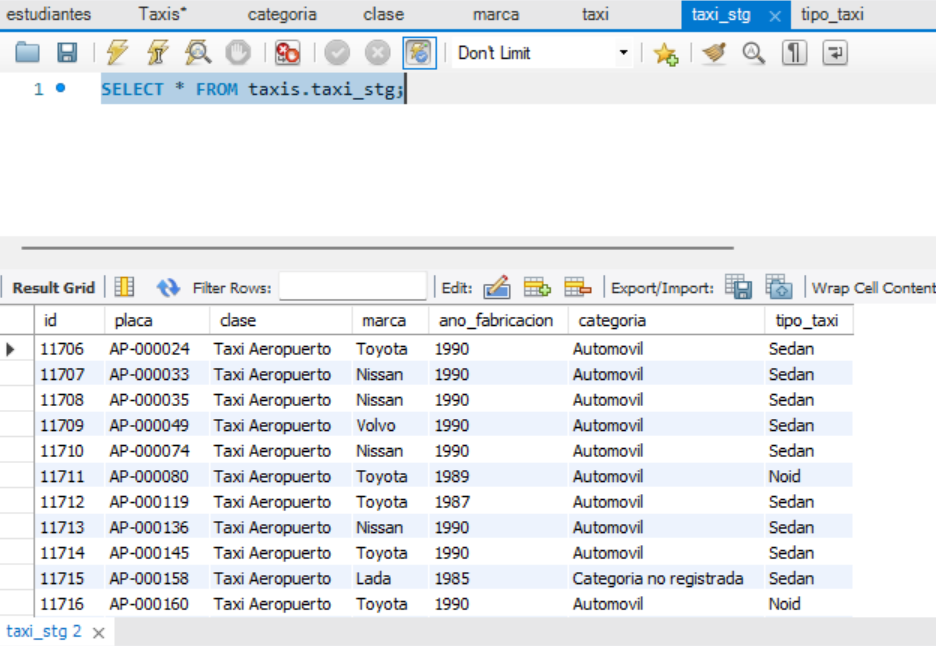

In [136]:
from IPython.display import Image

Image(filename='Taxi_stg.png')

### 3.4. Limpiar datos innecesarios

In [137]:
def limpiar1_datos_taxi_stg(conexion):
    try:
        # Desactivar las restricciones de clave externa para permitir la eliminación
        cursor = conexion.cursor()
        cursor.execute("SET FOREIGN_KEY_CHECKS=0;")
        cursor.close()

        # Eliminar datos de las tablas
        delete_queries = [
            'delete from taxi_stg where ano_fabricacion=0;',
            'delete from taxi_stg where marca like"%Marca%no%registrada%";',
            'delete from taxi_stg where categoria like"%Categoria%no%registrada%";',
            'delete from taxi_stg where tipo_taxi="Noid"'        
        ]

        for query in delete_queries:
            cursor = conexion.cursor()
            cursor.execute(query)
            cursor.close()

        # Confirmar los cambios
        conexion.commit()

        print("Datos tabla taxi stg limpiada exitosamente.")

    except Exception as e:
        print(f"Error al limpiar la base de datos: {e}")

    finally:
        try:
            # Reactivar las restricciones de clave externa
            cursor = conexion.cursor()
            cursor.execute("SET FOREIGN_KEY_CHECKS=1;")
            cursor.close()
        except Exception as e:
            print(f"Error al reactivar las restricciones de clave externa: {e}")

# Llamar a la función limpiar_datos_taxi_stg
limpiar1_datos_taxi_stg(conexion)


Datos tabla taxi stg limpiada exitosamente.


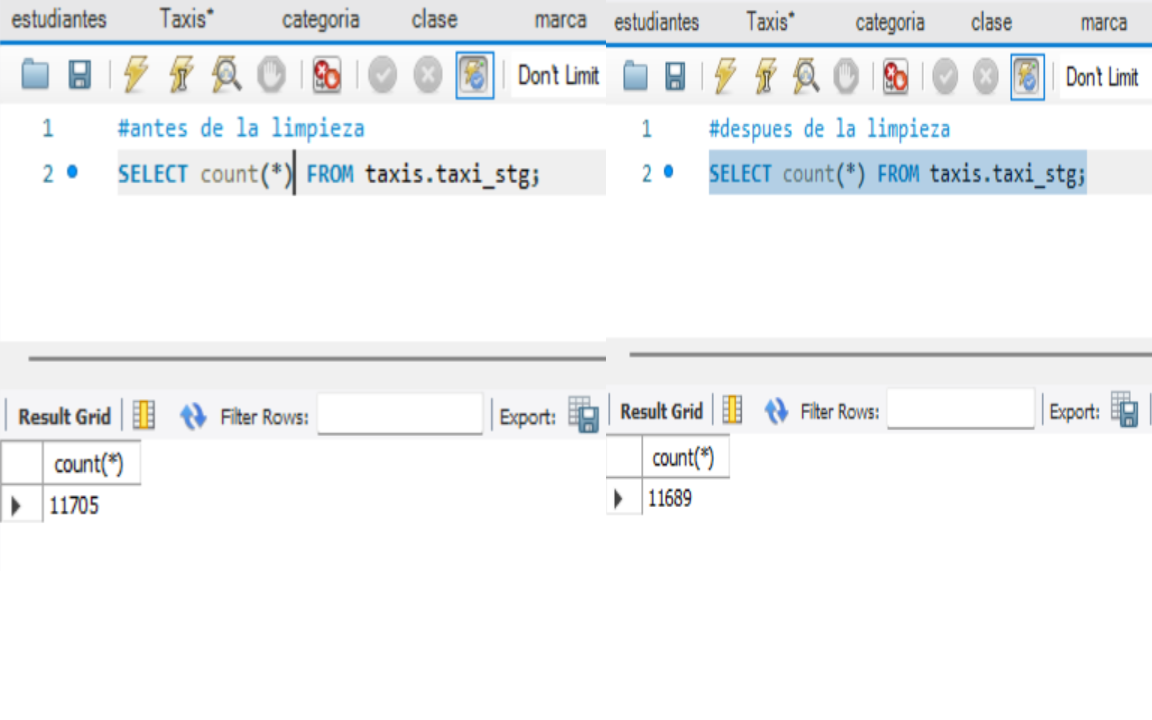

In [138]:
from IPython.display import Image

Image(filename='limpieza.png')

### 3.4. Obtener valores distintos y asignar a las respectivas tablas

In [139]:
def obtener_distinct_values(conexion, column_name):
    try:
        cursor = conexion.cursor()
        select_query = f"SELECT DISTINCT({column_name}) FROM taxi_stg"
        cursor.execute(select_query)
        distinct_values = cursor.fetchall()
        print(f"Datos extraidos correctamente de: {column_name}")
        return tuple(value[0] for value in distinct_values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []


In [140]:
distinct_values_categorias=obtener_distinct_values(conexion, "categoria")

Datos extraidos correctamente de: categoria


In [141]:
distinct_values_tipo_taxi=obtener_distinct_values(conexion, "tipo_taxi")

Datos extraidos correctamente de: tipo_taxi


In [142]:
distinct_values_clases=obtener_distinct_values(conexion, "clase")

Datos extraidos correctamente de: clase


In [143]:
distinct_values_marcas=obtener_distinct_values(conexion, "marca")

Datos extraidos correctamente de: marca


### 3.5. Insertar los datos extraidos en las respectivas tablas

In [144]:
def insert_distinct_values_into_table(conexion, distinct_values, table_name, column_name):
    try:
        # Abrir el cursor para ejecutar la inserción de datos
        cursor = conexion.cursor()

        # Definir la consulta de inserción
        insert_query = f"INSERT INTO {table_name} ({column_name}) VALUES (%s)"

        # Iterar sobre los valores distintos y ejecutar la inserción
        for value in distinct_values:
            cursor.execute(insert_query, (value,))

        # Confirmar los cambios y cerrar el cursor
        conexion.commit()
        cursor.close()

        print(f"Datos insertados correctamente en {table_name}.")

    except Exception as e:
        print(f"Error al insertar datos en {table_name}: {e}")

# Llamar a la función insert_distinct_values_into_table

In [145]:
insert_distinct_values_into_table(conexion, distinct_values_marcas, "marca", "descripcion_marca")

Datos insertados correctamente en marca.


In [146]:
insert_distinct_values_into_table(conexion, distinct_values_clases, "clase", "descripcion_clase")

Datos insertados correctamente en clase.


In [147]:
insert_distinct_values_into_table(conexion, distinct_values_categorias, "categoria", "descripcion_categoria")

Datos insertados correctamente en categoria.


In [148]:
insert_distinct_values_into_table(conexion, distinct_values_tipo_taxi, "tipo_taxi", "descripcion_tipo_taxi")

Datos insertados correctamente en tipo_taxi.


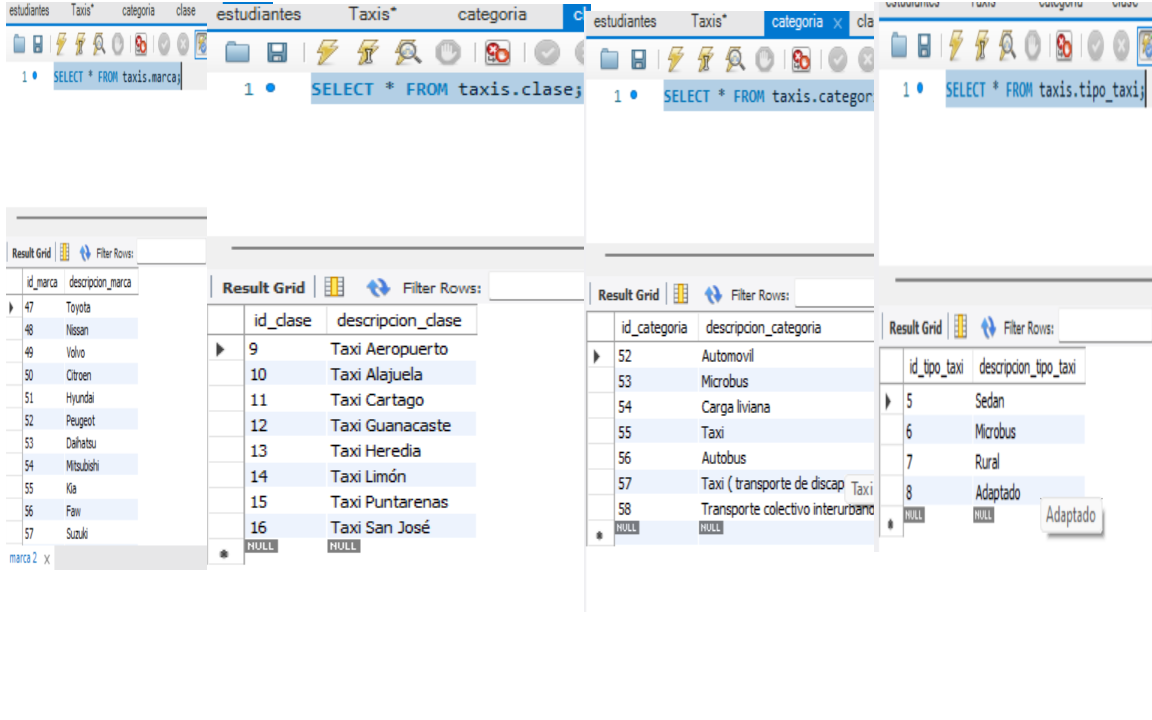

In [149]:
from IPython.display import Image

Image(filename='inserccion.png')

### 3.6. Obtener los valores relacionados con su respectivo ID

In [150]:
def obtener_valores_taxi(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT taxi_stg.placa, clase.id_clase, marca.id_marca, taxi_stg.ano_fabricacion, categoria.id_categoria, tipo_taxi.id_tipo_taxi 
            FROM taxi_stg
            INNER JOIN clase ON taxi_stg.clase = clase.descripcion_clase
            INNER JOIN marca ON taxi_stg.marca = marca.descripcion_marca
            INNER JOIN categoria ON taxi_stg.categoria = categoria.descripcion_categoria
            INNER JOIN tipo_taxi ON taxi_stg.tipo_taxi = tipo_taxi.descripcion_tipo_taxi;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

In [151]:
def obtener_valores_taxi(conexion):
    try:
        # Abrir el cursor para ejecutar la consulta
        cursor = conexion.cursor()

        # Definir la consulta SQL
        select_query = '''
        SELECT taxi_stg.placa, clase.id_clase, marca.id_marca, taxi_stg.ano_fabricacion, categoria.id_categoria, tipo_taxi.id_tipo_taxi 
        FROM taxi_stg
        INNER JOIN clase ON taxi_stg.clase = clase.descripcion_clase
        INNER JOIN marca ON taxi_stg.marca = marca.descripcion_marca
        INNER JOIN categoria ON taxi_stg.categoria = categoria.descripcion_categoria
        INNER JOIN tipo_taxi ON taxi_stg.tipo_taxi = tipo_taxi.descripcion_tipo_taxi;
        '''

        # Ejecutar la consulta
        cursor.execute(select_query)

        # Obtener los valores y cerrar el cursor
        values = cursor.fetchall()
        cursor.close()

        return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores de taxi: {e}")
        return ()



In [152]:
valores=obtener_valores_taxi(conexion)

### 3.7. Insertar los valores en la tabla Taxi

In [153]:
def insert_tabla_taxi(conexion, values):
    try:
        # Abrir el cursor para ejecutar la inserción de datos
        cursor = conexion.cursor()

        # Definir la consulta de inserción
        insert_query = "INSERT INTO taxi (placa, id_clase, id_marca, ano_fabricacion, id_categoria, id_tipo_taxi) VALUES (%s, %s, %s, %s, %s, %s)"

        # Iterar sobre los valores y ejecutar la inserción
        for value in values:
            cursor.execute(insert_query, value)

        # Confirmar los cambios y cerrar el cursor
        conexion.commit()
        cursor.close()

        print("Datos insertados correctamente.")

    except Exception as e:
        print(f"Error al insertar datos: {e}")

def cerrar_conexion(conexion):
    if conexion:
        conexion.close()



In [154]:
insert_tabla_taxi(conexion, valores)

Datos insertados correctamente.


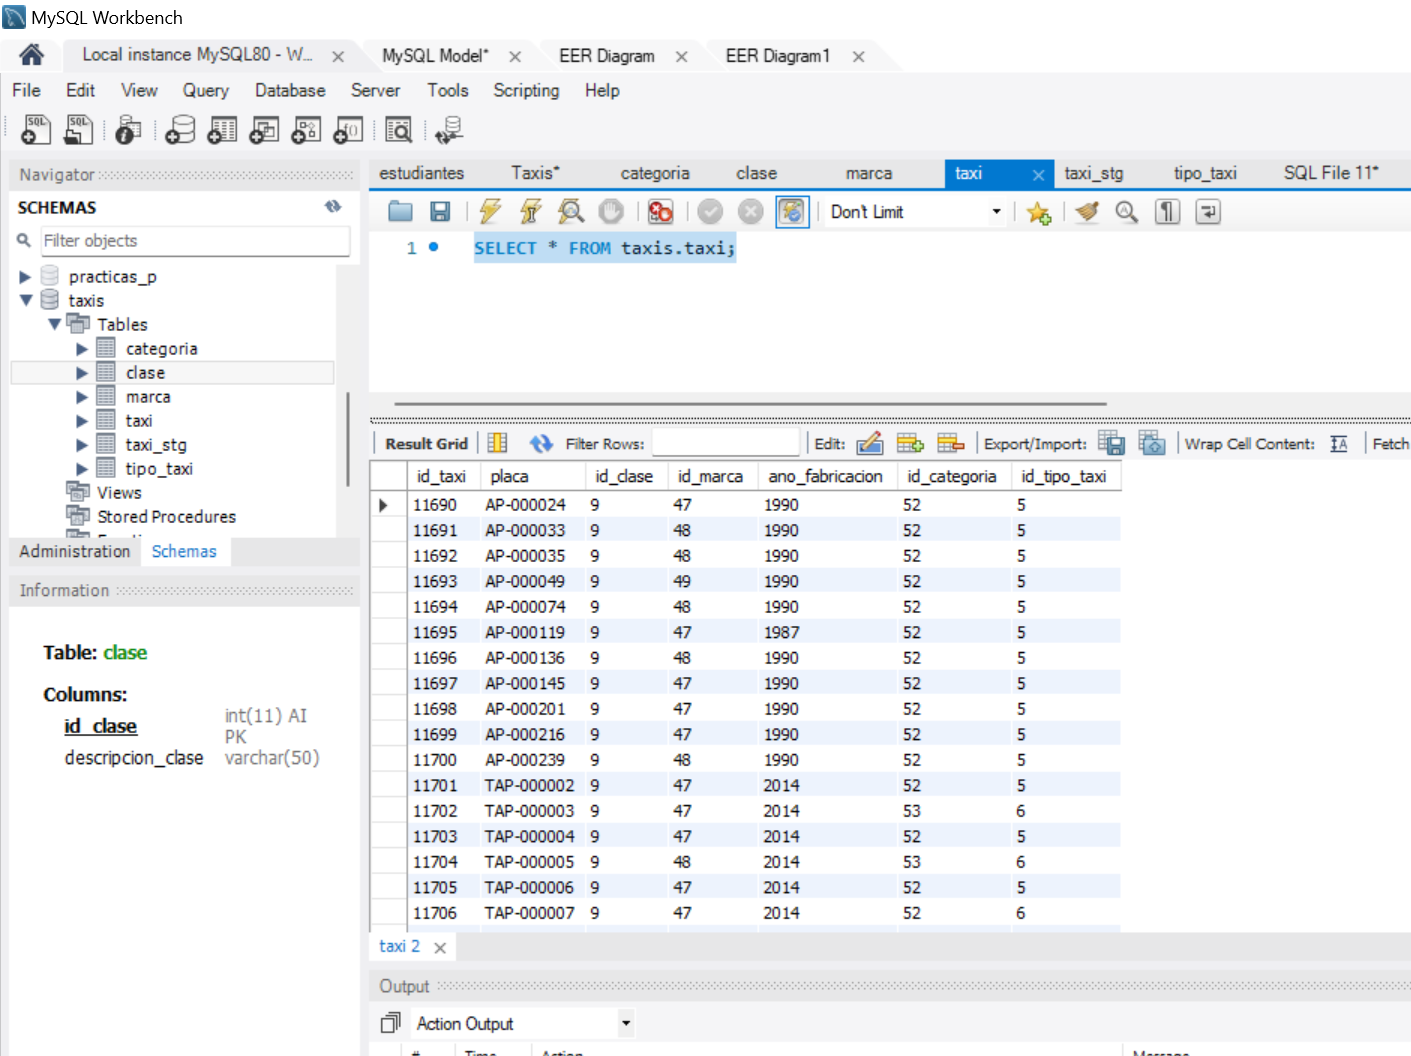

In [155]:
from IPython.display import Image

Image(filename='fin.png')

Comprobar en la base de datos que se hayan insertado los datos correctamente y responder a las siguientes preguntas:

### 1. Diseño de la Base de Datos:

¿Cuál es la estructura de la base de datos utilizada en la práctica? 
La base de datos "taxis" contiene las siguiente estructura:

1. **categoria**: Almacena información sobre las categorías de taxis, con campos `id_categoria` y `descripcion_categoria`.
2. **clase**: Contiene las clases de los taxis, con campos `id_clase` y `descripcion_clase`.
3. **marca**: Guarda información sobre las marcas de los taxis, con campos `id_marca` y `descripcion_marca`.
4. **tipo_taxi**: Almacena los tipos de taxi, con campos `id_tipo_taxi` y `descripcion_tipo_taxi`.
5. **taxi**: Esta tabla contiene información detallada sobre cada taxi, con campos como `id_taxi`, `placa`, `id_clase`, `id_marca`, `ano_fabricacion`, `id_categoria` y `id_tipo_taxi`. También incluye claves foráneas (`FK_TaxiClase`, `FK_TaxiMarca`, `FK_TaxiTipoTaxi`, `fk_categoria`) que hacen referencia a las tablas `clase`, `marca`, `tipo_taxi` y `categoria`, respectivamente.
6. **taxi_stg**: Es una tabla de almacenamiento temporal que parece es utilizada para cargar datos en la tabla principal `taxi`. Tiene campos similares a `taxi` pero sin claves foráneas.

Cada tabla tiene una estructura definida con campos específicos y claves primarias que garantizan la integridad de los datos.
¿Cómo están relacionadas las tablas entre sí?
Las tablas están relacionadas entre sí a través de claves foráneas que establecen conexiones entre los registros de diferentes tablas:

1. **taxi**:
   - La columna `id_clase` está relacionada con la tabla `clase` a través de la clave foránea `FK_TaxiClase`.
   - La columna `id_marca` está relacionada con la tabla `marca` a través de la clave foránea `FK_TaxiMarca`.
   - La columna `id_tipo_taxi` está relacionada con la tabla `tipo_taxi` a través de la clave foránea `FK_TaxiTipoTaxi`.
   - La columna `id_categoria` está relacionada con la tabla `categoria` a través de la clave foránea `fk_categoria`.

Estas relaciones aseguran que los valores en las columnas de las tablas de la base de datos `taxi` estén vinculados a los registros correspondientes en las tablas `clase`, `marca`, `tipo_taxi` y `categoria`y estas a su vez se relacionan con la tabla `taxi`.
### 2. Proceso de Extracción y Limpieza:

¿Cómo se realiza la extracción de datos desde el archivo Excel hacia un DataFrame de pandas?
Usamos un código que carga datos desde un archivo Excel llamado "Datos_Taxis.xls" en un DataFrame utilizando la biblioteca Pandas en Python.
¿Qué criterios se utilizaron para limpiar los datos innecesarios en la tabla taxi_stg?
El código que usamos para limpiar la tabla  `taxi_stg` cumplen con ciertos criterios como:

1. Eliminar registros con año de fabricación igual a 0.
2. Eliminar registros con marca no registrada.
3. Eliminar registros con categoría no registrada.
4. Eliminar registros con tipo de taxi igual a "Noid".

Estos criterios se utilizan para garantizar la integridad y calidad de los datos en la tabla `taxi_stg`.
### 3.Inserción de Datos:

¿Cuáles son los pasos específicos para insertar datos en la tabla taxi_stg desde el DataFrame de pandas?
Para insertar datos desde un DataFrame de Pandas en la tabla `taxi_stg`, se siguen estos pasos:

1. Se prepara un cursor y se define la consulta de inserción.
2. Se itera sobre cada fila del DataFrame.
3. Se obtienen los datos de cada fila.
4. Se ejecuta la consulta de inserción con los datos obtenidos.
5. Se confirman los cambios en la base de datos y se manejan las excepciones.
6. Se cierra el cursor.
¿Cómo se manejan los datos duplicados o los valores inconsistentes durante la inserción?
Los datos duplicados e inconsistentes son eliminados luego de la inserción
### 4.Obtención y Asignación de Valores Distintos:

¿Cómo se obtienen y asignan los valores distintos de las columnas categoria, tipo_taxi, clase y marca a sus respectivas tablas?
primero obtenemos los valores de las tablas usando el código que define una función llamada `obtener_distinct_values` que recibe una conexión a la base de datos y el nombre de una columna. Esta función ejecuta una consulta SQL para obtener los valores únicos de esa columna en la tabla `taxi_stg`. Luego, retorna una tupla con los valores distintos obtenidos. Si ocurre algún error durante el proceso, imprime un mensaje de error y retorna una lista vacía y para asignar los valores a las tablas se usa el código que define una función llamada `insert_distinct_values_into_table` que inserta valores distintos en una columna específica de una tabla en la base de datos. Utiliza un cursor para ejecutar las consultas de inserción. Después de insertar los valores, confirma los cambios en la base de datos y cierra el cursor. En caso de error, imprime un mensaje de error.
### 5.Relación de Datos y Carga Final:

¿Cómo se establecen las relaciones entre las tablas taxi_stg, clase, marca, categoria, tipo_taxi y taxi?
Las relaciones entre las tablas se establecen mediante consultas SQL INNER JOIN, donde los campos correspondientes de las tablas se igualan para relacionar registros. Específicamente:
taxi_stg se relaciona con clase, marca, categoria y tipo_taxi según los campos correspondientes en cada tabla.
¿Cuál es el proceso final para cargar los datos en la tabla taxi?
El proceso final para cargar los datos en la tabla `taxi` implica:

1. Obtener los valores relacionados de las tablas necesarias.
2. Insertar estos valores en la tabla `taxi` utilizando la función `insert_tabla_taxi()`.
3. Cerrar la conexión a la base de datos con la función `cerrar_conexion()`.

# PARTE 2. LECTURA DE DATOS DESDE LA BASE DE DATOS Y VISUALIZACIÓN DE DATOS
### Objetivos:
##### Extraer los datos desde la base de Datos
##### Análisis Exploratorio Efectivo: Enseñar técnicas fundamentales de análisis exploratorio de datos, incluida la identificación y manejo de valores faltantes, así como la exploración de estadísticas descriptivas, para obtener una comprensión inicial de los conjuntos de datos.
##### Visualización Impactante: Introducir conceptos clave de visualización de datos utilizando Matplotlib y Seaborn, y explorar la integración de "PowerClient - Quick Report" para generar visualizaciones impactantes que resalten patrones y tendencias de manera clara y efectiva.

### 1: Importación de librerías

In [93]:
!pip install mysql.connector

In [94]:
import pandas as pd
import mysql.connector
import pandas as pd

### 2: Cargar los datos

In [95]:
def establecer_conexion(host, user, password, database):
    try:
        conexion = mysql.connector.connect(
            host=host,
            user=user,
            password=password,
            database=database
        )
        return conexion
    except mysql.connector.Error as err:
        print(f"Error: {err}")
        return None

            
def obtener_valores_taxi(conexion):
    try:
        with conexion.cursor() as cursor:
            select_query = '''
            SELECT * from taxi_stg;
            '''
            cursor.execute(select_query)
            values = cursor.fetchall()
            return tuple(values)

    except Exception as e:
        print(f"Error al obtener valores distintos: {e}")
        return []

            
def cerrar_conexion(conexion):
    if conexion:
        conexion.close()


In [96]:
conexion = establecer_conexion("localhost", "root", "", "taxis")
conexion.is_connected()

True

In [97]:
datos_taxi=obtener_valores_taxi(conexion)

Error al obtener valores distintos: 'MySQLCursor' object does not support the context manager protocol


In [98]:
# Convertir la tupla en un DataFrame
columnas = ['Id','Placa', 'Clase', 'Marca', 'Año', 'Categoría', 'Tipo taxi']
df = pd.DataFrame(datos_taxi, columns=columnas)

In [99]:
df

,Id,Placa,Clase,Marca,Año,Categoría,Tipo taxi


In [100]:
# Eliminar la columna 'Id'
df = df.drop('Id', axis=1)

### 3: Librería Y-Data Profiling
https://docs.profiling.ydata.ai/4.6/ 

In [8]:
from ydata_profiling import ProfileReport

In [9]:
profile=ProfileReport(df,title="Análisis de datos")


In [10]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### 4: Librería sweetviz

In [11]:
import sweetviz as sv

In [12]:
advert_report=sv.analyze([df,"Reporte DATOS"])

                                             |          | [  0%]   00:00 -> (? left)

In [13]:
advert_report.show_html()

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


###  5: Librería Power Bi

In [14]:
#pip install powerbiclient

In [15]:
from powerbiclient import QuickVisualize, get_dataset_config

In [16]:
# Import the DeviceCodeLoginAuthentication class to authenticate against Power BI
from powerbiclient.authentication import DeviceCodeLoginAuthentication
    
# Initiate device authentication
device_auth = DeviceCodeLoginAuthentication()

Performing device flow authentication. Please follow the instructions below.
To sign in, use a web browser to open the page https://microsoft.com/devicelogin and enter the code FAK5J5UWA to authenticate.

Device flow authentication successfully completed.
You are now logged in .

The result should be passed only to trusted code in your notebook.


In [19]:
# Create a Power BI report from your data
PBI_visualize = QuickVisualize(get_dataset_config(df), auth=device_auth)

# Render new report
PBI_visualize

QuickVisualize()

## 6: Preguntas

### 6.1. Extracción de Datos:

Describe el proceso de extracción de datos desde la base de datos MySQL. 

¿Qué consulta SQL se utiliza para obtener los datos de la tabla taxi_stg?

### 6.2. Visualización con Y-Data Profiling:

Basándote en el informe de Y-Data Profiling, ¿qué información relevante se destaca sobre el conjunto de datos? ¿Cómo interpretarías los resultados del análisis?

### 6.3. Visualización con Sweetviz:

¿Cuáles son las principales visualizaciones proporcionadas por Sweetviz? ¿Puedes identificar patrones o tendencias interesantes en el conjunto de datos?

### 6.4. Visualización con Power BI:

Explica el proceso de autenticación utilizado para conectar Python a Power BI. ¿Cómo se genera y visualiza el informe en Power BI utilizando el conjunto de datos?

### 6.5. Comparación de Librerías:

¿Cuáles son las diferencias clave entre Y-Data Profiling, Sweetviz y Power BI en términos de funcionalidad y visualización? ¿En qué situaciones específicas podrías preferir una sobre la otra?

### 6.6. Ejercicio de extracción de la tabla taxi con sus relaciones:

Realiza la exportación de los datos de la tabla taxi y sus relaciones y modela el dataframe similar al dado.

